<a href="https://colab.research.google.com/github/VaneezaAhmad/Text-Prediction/blob/main/Urdu_predictive_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

There is a ton of Language modeling and Natural Language Processing work done in English and other popular languages. This project is generating the predictions of words in Urdu which is the national language of Pakistan and the is popular in South East Asia. This prediction model can be used in many ways such for creating a virtual assistant, for a search engines or keyboard predictive text or for chatbots. This can make typing easier and faster for Urdu keyboard users.

# Data Collection

Data was collected from https://www.kaggle.com/disisbig/urdu-wikipedia-articles. The author of the dataset had over 100,000 wikipedia articles in urdu. For this project only 1000 of those articles were used. 

## Import in relevant libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import nltk

In [4]:
import spacy

In [5]:
import tensorflow as tf


In [6]:
from nltk.probability import FreqDist

In [7]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [8]:
import pickle
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

# Read in data

Read in multiple files together


In [ ]:
import glob

def read_first_line(file):
    """Gets the first line from a file.

    Returns
    -------
    str
        the first line text of the input file
    """
    with open(file, 'rt') as fd:
        first_line = fd.readline()
    return first_line

def merge_per_folder(folder_path, output_filename):
    """Merges first lines of text files in one folder, and
    writes combined lines into new output file

    Parameters
    ----------
    folder_path : str
        String representation of the folder path containing the text files.
    output_filename : str
        Name of the output file the merged lines will be written to.
    """
    # make sure there's a slash to the folder path 
    folder_path += "" if folder_path[-1] == "/" else "/"
    # get all text files
    txt_files = glob.glob(folder_path + "*.txt")
    # get first lines; map to each text file (sorted)
    output_strings = map(read_first_line, sorted(txt_files))
    output_content = "".join(output_strings)
    # write to file
    with open(folder_path + output_filename, 'wt') as outfile:
        outfile.write(output_content)

In [9]:
from google.colab import files
uploaded = files.upload()


Saving data.txt to data.txt


In [ ]:
# read_first_line("urdu-data/1.txt")

In [ ]:
merge_per_folder("urdu-data", "data.txt")

FileNotFoundError: ignored

In [10]:
urdu =  open("data.txt", "r", encoding="utf_8").read()

In [11]:
len(urdu)

147477

# Preprocessing

## Spacy

In [13]:
nlp = spacy.blank("ur")

In [14]:
doc = nlp(urdu)

In [15]:
punctuation=["۔؟،\nn\1234567890"]

In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removal of special and unnecessary characters

In [17]:
urdu_words = [token.text for token in doc if token.text not in "′″،۔؟،ء\n-\n\n-.\n ./;:°،ء'"]


In [18]:
urdu_words = [token for token in urdu_words if token not in "،‘‘..{.,′″،/،ء'،./°،ء'.-""'-.[\‘‘؎،)‘"]


In [33]:
urdu_words = [token for token in urdu_words if token not in "·èøēŁłąśóżóțŁ'ù'ó'à'Î'é"]

In [38]:
urdu_words = [token for token in urdu_words if token not in "،،\n \n،,\n,,\n\n,,,\n\n\n,,,,\n\n\n\n\t\t\t\t\t\t\t\t\n"]

In [43]:
urdu_words = [token for token in urdu_words if token not in ")‘‘کوما': 2؛)‘‘کوما)‘‘شونین)‘‘شونین': 1"]

In [22]:
urdu_words = [token for token in urdu_words if token not in string.punctuation]

Removal of numbers and english words and letters 

In [23]:
urdu_words = [word.translate(str.maketrans('', '', '..."0123456789!+-')) \
                  for word in urdu_words]

In [24]:
urdu_words = [word.translate(str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')) \
                  for word in urdu_words]

In [25]:
urdu_words=[word for word in urdu_words if word != '']

In [26]:
len(urdu_words)

29192

Frequency Distribution of the top 50 words 

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)


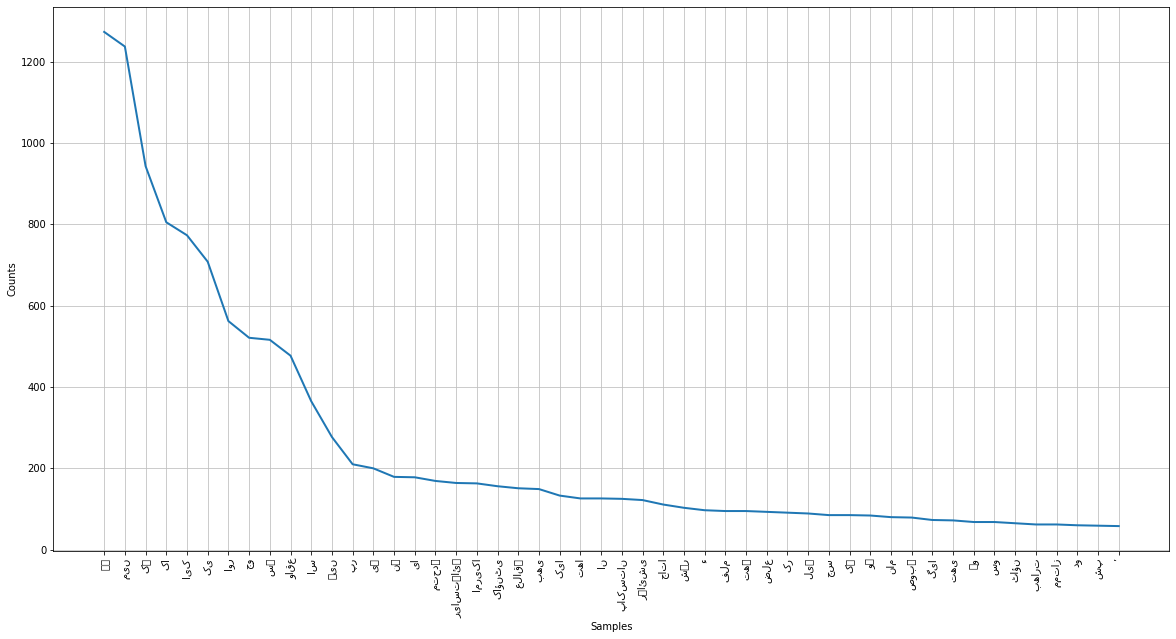

In [27]:
fdist = FreqDist(urdu_words)
plt.figure(figsize=(20, 10))
fdist.plot(50);

In [28]:
urdu_words[:10]

['زیورخ',
 'کیلیفورنیا',
 'ریاستہائے',
 'متحدہ',
 'امریکا',
 'کا',
 'ایک',
 'انانکارپوریٹڈ',
 'علاقہ',
 'جو']

Taking the unique words and creating a dictionary containing each word and an index for that word

In [44]:
unique_words = np.unique(urdu_words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [45]:
unique_word_index

{'ء': 0,
 'آ': 1,
 'آئر': 2,
 'آئرائی': 3,
 'آئرس': 4,
 'آئرش': 5,
 'آئرلینڈ': 6,
 'آئس': 7,
 'آئن': 8,
 'آئون': 9,
 'آئی': 10,
 'آئینہ': 11,
 'آئیوس': 12,
 'آئیووا': 13,
 'آئیں': 14,
 'آئے': 15,
 'آب': 16,
 'آباد': 17,
 'آبادی': 18,
 'آبادیات': 19,
 'آبادیاتی': 20,
 'آبادیوں': 21,
 'آبرود': 22,
 'آبشار': 23,
 'آبشاروں': 24,
 'آبنائے': 25,
 'آتا': 26,
 'آتش': 27,
 'آتشزدگی': 28,
 'آتشی': 29,
 'آتی': 30,
 'آتیں': 31,
 'آتے': 32,
 'آثار': 33,
 'آج': 34,
 'آجائیں': 35,
 'آجاتا': 36,
 'آجانا': 37,
 'آخر': 38,
 'آخری': 39,
 'آدبودووا': 40,
 'آدمز': 41,
 'آدمی': 42,
 'آدھی': 43,
 'آدیامان': 44,
 'آذربائجان': 45,
 'آذربائیجان': 46,
 'آر': 47,
 'آرائش': 48,
 'آرادان': 49,
 'آرال': 50,
 'آرام': 51,
 'آراین': 52,
 'آرایک': 53,
 'آرتوین': 54,
 'آرتھر': 55,
 'آرتھوڈوکس': 56,
 'آرزو': 57,
 'آرمینیا': 58,
 'آرٹسشعبہ': 59,
 'آرکنساس': 60,
 'آریہ': 61,
 'آزاد': 62,
 'آزادی': 63,
 'آزار': 64,
 'آزما': 65,
 'آزہیگوڈی': 66,
 'آسام': 67,
 'آسان': 68,
 'آسمان': 69,
 'آسٹریلیا': 70,
 'آسگوڈ': 71,
 'آغاز': 7

In [46]:
len(unique_word_index)

5778

In [47]:
unique_words[:20]

array(['ء', 'آ', 'آئر', 'آئرائی', 'آئرس', 'آئرش', 'آئرلینڈ', 'آئس', 'آئن',
       'آئون', 'آئی', 'آئینہ', 'آئیوس', 'آئیووا', 'آئیں', 'آئے', 'آب',
       'آباد', 'آبادی', 'آبادیات'], dtype='<U24')

In [146]:
unique_words.save('uniquewords.h5')
dump(unique_words, open('uniquewords.pkl', 'wb'))

## Separation of Target and Variables 

Taking the first three words from the list of words and making it the feature and the next word (4th word) as the target.  

In [48]:
WORD_LENGTH = 3
prev_words = []
next_words = []
for i in range(len(urdu_words) - WORD_LENGTH):
    prev_words.append(urdu_words[i:i + WORD_LENGTH])
    next_words.append(urdu_words[i + WORD_LENGTH])
print(prev_words[:5])
print(next_words[:5])

[['زیورخ', 'کیلیفورنیا', 'ریاستہائے'], ['کیلیفورنیا', 'ریاستہائے', 'متحدہ'], ['ریاستہائے', 'متحدہ', 'امریکا'], ['متحدہ', 'امریکا', 'کا'], ['امریکا', 'کا', 'ایک']]
['متحدہ', 'امریکا', 'کا', 'ایک', 'انانکارپوریٹڈ']


In [ ]:
pd.DataFrame()

Converting the words into 0's and 1's

In [49]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    y[i, unique_word_index[next_words[i]]] = 1

In [50]:
len(X), len(y), X.shape, y.shape

(29150, 29150, (29150, 3, 5778), (29150, 5778))

# Models


## FSM

Creating a simple model with one lstm layer, one dense layer and a output layer to check the performance of the model.  

In [51]:
model = Sequential()
model.add(LSTM(32, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
history=model.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

Epoch 1/100
433/433 [==============================] - 21s 8ms/step - loss: 6.9982 - accuracy: 0.0659 - top_k_categorical_accuracy: 0.1510 - val_loss: 6.4093 - val_accuracy: 0.1653 - val_top_k_categorical_accuracy: 0.2252
Epoch 2/100
433/433 [==============================] - 2s 6ms/step - loss: 5.9373 - accuracy: 0.1752 - top_k_categorical_accuracy: 0.2395 - val_loss: 6.5183 - val_accuracy: 0.1920 - val_top_k_categorical_accuracy: 0.2705
Epoch 3/100
433/433 [==============================] - 2s 6ms/step - loss: 5.7764 - accuracy: 0.2211 - top_k_categorical_accuracy: 0.2802 - val_loss: 6.9886 - val_accuracy: 0.2064 - val_top_k_categorical_accuracy: 0.2992
Epoch 4/100
433/433 [==============================] - 2s 6ms/step - loss: 5.8511 - accuracy: 0.2578 - top_k_categorical_accuracy: 0.3059 - val_loss: 7.2216 - val_accuracy: 0.1968 - val_top_k_categorical_accuracy: 0.3201
Epoch 5/100
433/433 [==============================] - 2s 6ms/step - loss: 5.8641 - accuracy: 0.2886 - top_k_catego

In [53]:
model.save('urdu-modelfsm.h5')
pickle.dump(history, open("urdu-resultsfsm.p", "wb"))

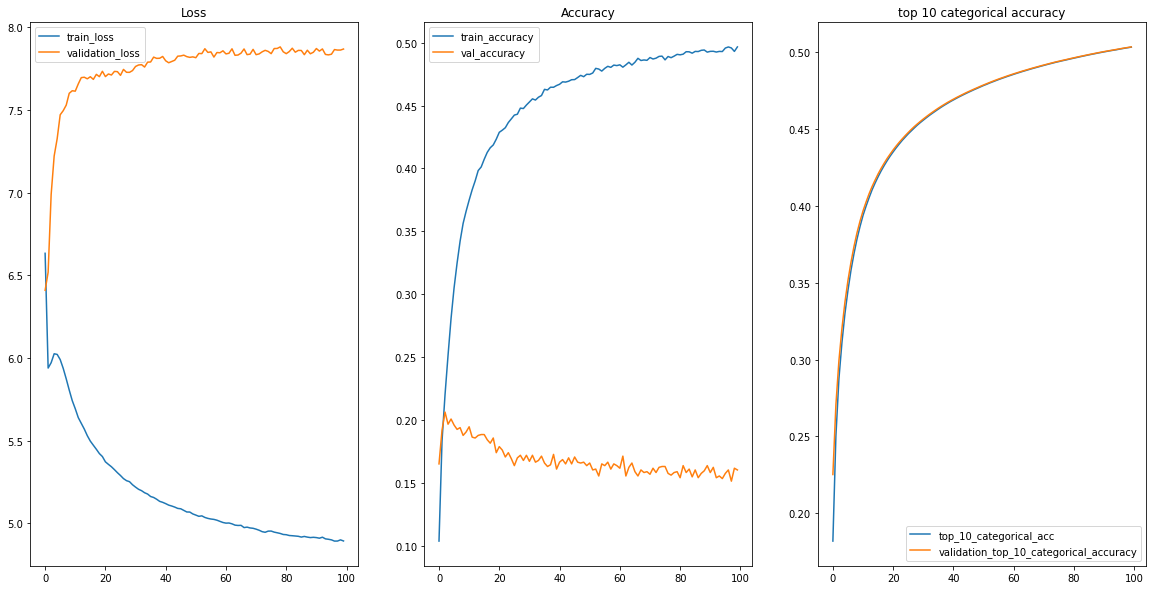

In [54]:
train_loss = history['loss']
train_acc = history['accuracy']
val_loss =history['val_loss']
val_acc = history['val_accuracy']
train_top_acc = history["top_k_categorical_accuracy"]
val_top_acc = history["val_top_k_categorical_accuracy"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.plot(train_loss, label='train_loss')
ax1.plot(val_loss, label='validation_loss')
ax1.set_title("Loss")
ax1.legend()

ax2.plot(train_acc, label='train_accuracy')
ax2.plot(val_acc, label='val_accuracy')
ax2.set_title("Accuracy")
ax2.legend()

ax3.plot(train_top_acc, label='top_10_categorical_acc')
ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
ax3.set_title("top 10 categorical accuracy")
ax3.legend()

The graphs above shows using the accuracy measure top_k_categoricalAccuracy that the model is doing well in regards to variance and there is a 50% chance that the target is in the top 5 predicted words. 

## Model 1 (2 LSTM layers, learning rate=0.001)

Adding another LSTM layer along with increasing the number of nodes. Adding two dropout layers for regularization. 

In [123]:
model1 = Sequential()
model1.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(128))
model1.add(Dropout(0.3))
model1.add(Dense(y.shape[1], activation='relu'))
model1.add(Activation("softmax"))
print(model1.summary())

optimizer = RMSprop(learning_rate=0.001)

model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 3, 128)            3024384   
_________________________________________________________________
dropout_116 (Dropout)        (None, 3, 128)            0         
_________________________________________________________________
lstm_118 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 5778)              745362    
_________________________________________________________________
activation_59 (Activation)   (None, 5778)              0         
Total params: 3,901,330
Trainable params: 3,901,330
Non-trainable params: 0
___________________________________________

In [124]:
results1=model1.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

Epoch 1/100
433/433 [==============================] - 8s 10ms/step - loss: 7.9307 - accuracy: 0.0422 - top_k_categorical_accuracy: 0.1489 - val_loss: 7.6095 - val_accuracy: 0.0480 - val_top_k_categorical_accuracy: 0.1639
Epoch 2/100
433/433 [==============================] - 3s 8ms/step - loss: 7.7161 - accuracy: 0.0438 - top_k_categorical_accuracy: 0.1656 - val_loss: 7.5753 - val_accuracy: 0.0583 - val_top_k_categorical_accuracy: 0.1712
Epoch 3/100
433/433 [==============================] - 3s 8ms/step - loss: 7.7087 - accuracy: 0.0481 - top_k_categorical_accuracy: 0.1718 - val_loss: 7.5285 - val_accuracy: 0.0720 - val_top_k_categorical_accuracy: 0.1751
Epoch 4/100
433/433 [==============================] - 3s 8ms/step - loss: 7.6667 - accuracy: 0.0572 - top_k_categorical_accuracy: 0.1757 - val_loss: 7.4834 - val_accuracy: 0.0905 - val_top_k_categorical_accuracy: 0.1783
Epoch 5/100
433/433 [==============================] - 3s 8ms/step - loss: 7.5423 - accuracy: 0.0798 - top_k_catego

In [125]:
model1.save('urdu-model1.h5')
pickle.dump(results1, open("urdu-results1.p", "wb"))

### graph function to display metric performance

In [59]:
def graph(results):
  train_loss = results['loss']
  train_acc = results['accuracy']
  train_top_acc = results["top_k_categorical_accuracy"]
  val_loss =results['val_loss']
  val_acc = results['val_accuracy']
  val_top_acc = results["val_top_k_categorical_accuracy"]

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

  ax1.plot(train_loss, label='train_loss')
  ax1.plot(val_loss, label='validation_loss')
  ax1.set_title("Loss")
  ax1.legend()

  ax2.plot(train_acc, label='train_accuracy')
  ax2.plot(val_acc, label='val_accuracy')
  ax2.set_title("Accuracy")
  ax2.legend()

  ax3.plot(train_top_acc, label='top_10_categorical_acc')
  ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
  ax3.set_title("Top 10 categorical accuracy")
  ax3.legend()

In [73]:
model = load_model('urdu-model1.h5')
# history = pickle.load(open("historygs.p", "rb"))

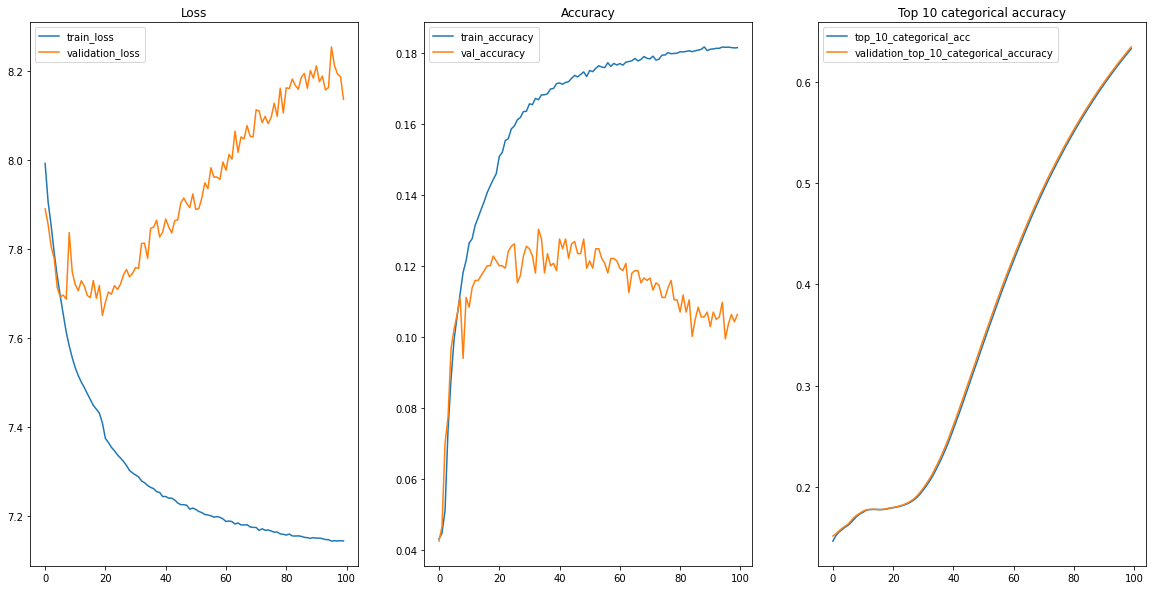

In [74]:
graph(results1)

Looking at top_k_categorical accuracy, this model performed well, with over 60% accuracy and very little variance in the training and validation set. 

## Model 2 (LSTM 256 nodes, learning rate=0.01)

Increasing the number of nodes in the LSTM layers to check how the model will perform. 

In [126]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(256))
model2.add(Dropout(0.3))
model2.add(Dense(y.shape[1], activation='relu'))
model2.add(Activation("softmax"))
print(model2.summary())

optimizer = RMSprop(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)
results2=model2.fit(X,y, epochs=100, batch_size=64, validation_split=0.05).history

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 3, 256)            6179840   
_________________________________________________________________
dropout_118 (Dropout)        (None, 3, 256)            0         
_________________________________________________________________
lstm_120 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_119 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 5778)              1484946   
_________________________________________________________________
activation_60 (Activation)   (None, 5778)              0         
Total params: 8,190,098
Trainable params: 8,190,098
Non-trainable params: 0
___________________________________________

In [127]:
model2.save('urdu-model2.h5')
pickle.dump(results2, open("urdu-results2.p", "wb"))

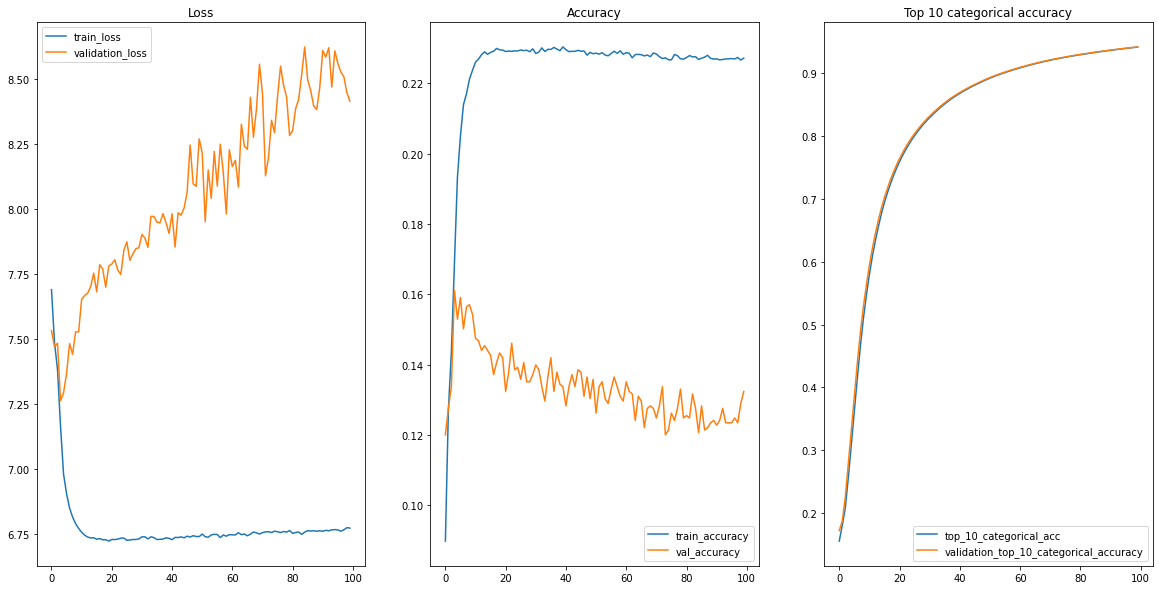

In [63]:
graph(results2)

From the graphs we can see this model is performing a lot better. As our epochs increase, there is over a 90% chance that out target is in the top 5 predicted words. There is very little variance in the validation and train set. 

## Model 3 (batch size=10)

In [128]:
#batch size=10, lr=0.001(best)

model3 = Sequential()
model3.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(256))
model3.add(Dropout(0.3))
model3.add(Dense(y.shape[1], activation='relu'))
model3.add(Activation("softmax"))
print(model3.summary())

optimizer = RMSprop(learning_rate=0.001)

model3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)
results3=model3.fit(X,y, epochs=100, batch_size=10, validation_split=0.05).history

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 3, 256)            6179840   
_________________________________________________________________
dropout_120 (Dropout)        (None, 3, 256)            0         
_________________________________________________________________
lstm_122 (LSTM)              (None, 256)               525312    
_________________________________________________________________
dropout_121 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 5778)              1484946   
_________________________________________________________________
activation_61 (Activation)   (None, 5778)              0         
Total params: 8,190,098
Trainable params: 8,190,098
Non-trainable params: 0
___________________________________________

In [129]:
model3.save('urdu-model3.h5')
pickle.dump(results3, open("urdu-results3.p", "wb"))

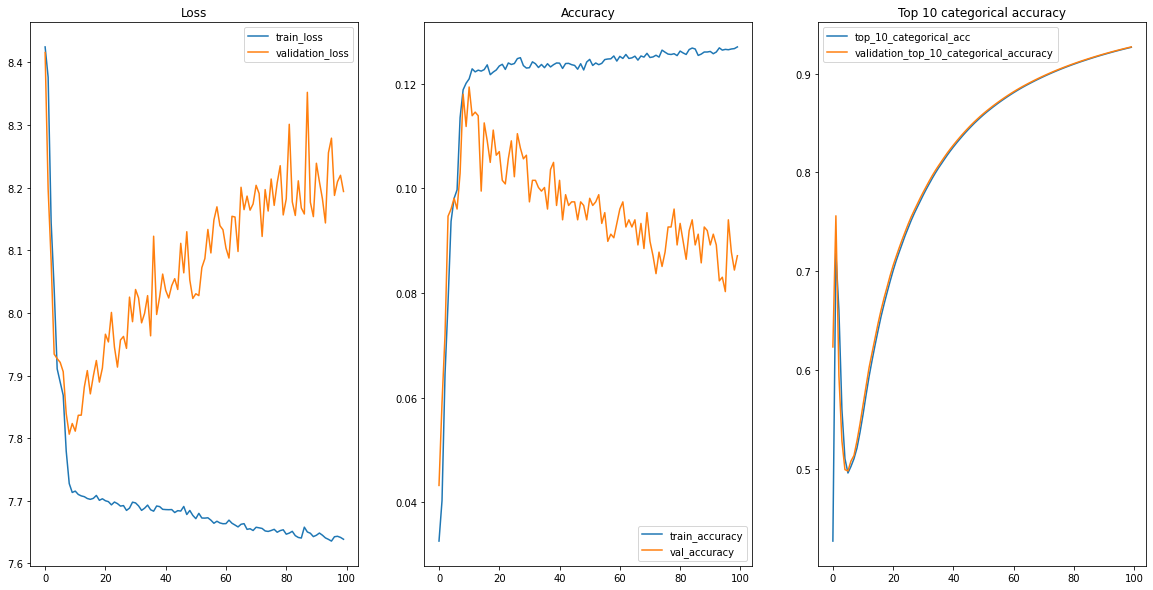

In [66]:
graph(results3)

## Model 4 (Grid Search)

Trying Multiple batch sizes, epochs and optimizers to check the best parameters that would make the model perform the best

In [67]:
def model(optimizer="RMSprop(learning_rate=0.001)"):
  model = Sequential()
  model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(256))
  model.add(Dropout(0.3))
  model.add(Dense(y.shape[1], activation='relu'))
  model.add(Activation("softmax"))
  # print(model.summary())
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

  return model

In [68]:
model = KerasClassifier(build_fn=model, verbose=1)

In [69]:

param_grid = {
    'epochs': [50,100,150], 
    'batch_size':[32,62,128],
    'optimizer':['RMSprop', 'Adam'],
    # 'kc__dropout': [0.5, 0.4, 0.3, 0.2, 0.1, 0]
}

kfold_splits = 3
grid = GridSearchCV(model,  
                    n_jobs=1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,  #StratifiedKFold(n_splits=kfold_splits, shuffle=True)
                    param_grid=param_grid)

In [70]:
grid_result = grid.fit(X, y) 

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Streaming output truncated to the last 5000 lines.
Epoch 74/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1781 - accuracy: 0.2883 - top_k_categorical_accuracy: 0.5079
Epoch 75/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1354 - accuracy: 0.2923 - top_k_categorical_accuracy: 0.5131
Epoch 76/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1776 - accuracy: 0.2889 - top_k_categorical_accuracy: 0.5181
Epoch 77/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1448 - accuracy: 0.2911 - top_k_categorical_accuracy: 0.5230
Epoch 78/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1629 - accuracy: 0.2892 - top_k_categorical_accuracy: 0.5279
Epoch 79/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1414 - accuracy: 0.2911 - top_k_categorical_accuracy: 0.5326
Epoch 80/150
314/314 [==============================] - 4s 12ms/step - loss: 6.1292 - accuracy: 0.2923 - top_

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 360.4min finished


Epoch 1/100
228/228 [==============================] - 6s 11ms/step - loss: 7.8173 - accuracy: 0.0372 - top_k_categorical_accuracy: 0.1386
Epoch 2/100
228/228 [==============================] - 3s 11ms/step - loss: 7.1637 - accuracy: 0.0434 - top_k_categorical_accuracy: 0.1681
Epoch 3/100
228/228 [==============================] - 3s 11ms/step - loss: 7.0566 - accuracy: 0.0534 - top_k_categorical_accuracy: 0.1784
Epoch 4/100
228/228 [==============================] - 3s 11ms/step - loss: 6.8753 - accuracy: 0.0900 - top_k_categorical_accuracy: 0.1883
Epoch 5/100
228/228 [==============================] - 3s 11ms/step - loss: 6.6695 - accuracy: 0.1375 - top_k_categorical_accuracy: 0.2015
Epoch 6/100
228/228 [==============================] - 3s 11ms/step - loss: 6.4551 - accuracy: 0.1740 - top_k_categorical_accuracy: 0.2158
Epoch 7/100
228/228 [==============================] - 3s 11ms/step - loss: 6.3233 - accuracy: 0.1959 - top_k_categorical_accuracy: 0.2288
Epoch 8/100
228/228 [======

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Predictions

The model that performed the best according to the top-k categorical accuracy is model 3, which will be used to make predictions 

In [130]:
pmodel = load_model('urdu-model2.h5')
# umodel=load_model('urdu-model1.h5')
# model=load_model("urdu-model3.h5")
fmodel=load_model("urdu-modelfsm.h5")

In [131]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("کیلیفورنیا ریاستہائے متحدہ")

کیلیفورنیا
ریاستہائے
متحدہ


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [132]:
import heapq
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [154]:
def predict_completions(model, text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [155]:
def predict(model):
  q =  input("ENTER TEXT: ")
  # print("correct sentence: ",q)
  seq =  q #" ".join(q)#tokenized.tokenize(q.lower())[0:3])
  print("Sequence: ",seq)
  print("next possible words: ", predict_completions(model, seq, 5))

Most of the models are giving the same words as predictions, in which all 5 are wrong. Except the first simple model which is giving 3-4 out of 5 words correct and Model 1 which is giving 1 out of 5 words correct

In [156]:
predict(model)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [157]:
predict(model1)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['کا', 'ء', 'آ', 'آئر', 'آئرائی']


In [158]:
predict(model2)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [159]:
predict(model3)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [160]:
predict(fmodel)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['بعد', 'لیے', 'پہلے', 'یہ', 'علاوہ']


In [83]:
predict()

ENTER TEXT: آوٹ پٹ کی
Sequence:  آوٹ پٹ کی
آوٹ
پٹ
کی
next possible words:  ['اور', 'ء', 'آ', 'آئر', 'آئرائی']


In [84]:
predict()

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [85]:
predict()

ENTER TEXT:  یہاں کی آبادی
Sequence:   یہاں کی آبادی
یہاں
کی
آبادی
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [89]:
predict()

ENTER TEXT:  یہاں کی آبادی
Sequence:   یہاں کی آبادی
یہاں
کی
آبادی
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [90]:
predict()

ENTER TEXT: لوگو ایک نشان
Sequence:  لوگو ایک نشان
لوگو
ایک
نشان
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [91]:
predict()

ENTER TEXT: کیلیفورنیا ریاستہائے متحدہ
Sequence:  کیلیفورنیا ریاستہائے متحدہ
کیلیفورنیا
ریاستہائے
متحدہ
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [97]:
predict()

ENTER TEXT: کیلیفورنیا ریاستہائے متحدہ
Sequence:  کیلیفورنیا ریاستہائے متحدہ
کیلیفورنیا
ریاستہائے
متحدہ
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [99]:
predict()

ENTER TEXT: وہ موحدین کا
Sequence:  وہ موحدین کا
وہ
موحدین
کا
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [105]:
predict()

ENTER TEXT: وہ موحدین کا
Sequence:  وہ موحدین کا
وہ
موحدین
کا
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [113]:
predict()

ENTER TEXT: وہ موحدین کا
Sequence:  وہ موحدین کا
وہ
موحدین
کا
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [114]:
predict(
)

ENTER TEXT: آوٹ پٹ کی
Sequence:  آوٹ پٹ کی
آوٹ
پٹ
کی
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


model1, model2 and model3 are all giving the same results. 

In [120]:
predict()

ENTER TEXT: آوٹ پٹ کی
Sequence:  آوٹ پٹ کی
آوٹ
پٹ
کی
next possible words:  ['اور', 'ایک', 'جن', 'تھے', 'بھی']


For FSM model, 3 out 5 predictions are correct and make sense. 

In [122]:
predict()

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['بعد', 'لیے', 'پہلے', 'یہ', 'علاوہ']


4 out of 5 predictions are correct.

In [146]:
predict()

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [149]:
predict()

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['کا', 'ء', 'آ', 'آئر', 'آئرائی']


In [152]:
predict()

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']
